# <center>Structural Analysis and Visualization of Networks</center>

## <center>Home Assignment #4: Community Detection Algorithms

### <center>Student: *Khomyuk Oleg*</center>

#### <hr /> General Information

**Due Date:** 03.04.2016 23:59 <br \>
**Late submission policy:** the task will not be graded! <br \>

Please send your reports to <mailto:network.hse.2016@gmail.com> with message subject of the following structure:<br \>
**[HSE Networks 2016] *{LastName}* *{First Name}* HA*{Number}***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<hr \>

# Problems

## Task 1. Implement Markov Cluster Algorithm

Implement [Markov Cluster Algorithm](http://micans.org/mcl/) (MCL).

**Input:** Transition matrix $T = D^{-1}A$

**Output:** Adjacency matrix $M^*$

1. Set $M = T$
2. **repeat:**
    3. *Expansion Step:* $M = M^p$ (usually $p=2$)
    4. *Inflation Step:* Raise every entry of $M$ to the power $\alpha$ (usualy $\alpha=2$)
    5. *Renormalize:* Normalize each row by its sum
    6. *Prunning:* Replace entries that are close to $0$ by pure $0$
7. **until** $M$ converges
8. $M^* = M$
<br\>
<br\>

As a result you should get a cluster matrix s.t. elements of the cluster correspont to nonzero elements of the columns of the matrix. 
<br\>
* Run this method for network [1](https://www.dropbox.com/s/so0ly2ozh2pzxp6/network1.mat?dl=0), [2](https://www.dropbox.com/s/xcswyhoeehq95v2/network2.mat?dl=0) and [3](https://www.dropbox.com/s/cwshsfr2d8fn470/network3.mat?dl=0).
* Play with the parameters ($p$, $\alpha$, zero tolerance), analyse the results

<hr />

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from scipy import io, stats
import scipy.sparse as spma
import scipy.sparse.linalg as spla
import operator

In [2]:
n1_data = io.loadmat('network1.mat')
n2_data = io.loadmat('network2.mat')
n3_data = io.loadmat('network3.mat')

A1=n1_data['A']
A2=n2_data['A']
A3=n3_data['A']

In [3]:
from numpy import linalg as la

def MCL(A, p, alpha, threshold):
    
    K = A.sum(axis=0)
    D = spma.dia_matrix((K, 0), shape=A.shape)
    T = np.dot(la.inv(D.todense()),A)
    M = T
    
    while True:
        M_old = M
        M = la.matrix_power(M, p)
        M = np.power(M,alpha)
        M=M/np.sum(M,axis=1, keepdims=True)
        low_values_indices = M < threshold 
        M[low_values_indices] = 0
        metric = np.max(M-M_old)
        if metric < threshold:
            break   
    return M

The agorithm is desinged to transform the graph connectivity in such a way as to disconnect different communities and concentrate connectivity within one.

At each iteration the algorithm cacluates a new transition kernel, based on the **$p$-hop importance score** $u_{ij}$ of connectivity of nodes $i$ and $j$ in the original kernel.

The score is a nonlinear transformation of the $p$-hop connectivity probability $\pi^p_{sd} = \mathbb{P}( s\rightarrow_p d )$, which reflects the chances of reaching any node $d$ from a vertex $s$ in $p$-hops. 

The procedure consists of "pruning" and "inflation" steps. At the pruning step, the algorithm zeroes the $p$-hop transition prbabilities lower that a $\theta$. The rationale is, that if the random walk from $i$ is unlikely to end up in vertex $j$ in $p$ hops, then the $i\sim j$ path is not likely to connect vertices within one community. Thus the pairs of nodes $(i,j)$ with $p$-hop transition probability $\pi_{ij}^p$ lower than the threshold are forcefully disconnected. However, if the nodes $i$ and $j$ belong to the same community, the higher is the chance that a random walk reaches $j$ from $i$. Therefore zeroing negligible in effect severs weak between community connections.

At next step the remaining non-zero $\pi_{ij}^p$ are damped by a power transformation with parameter $\alpha>1$ to get the **importance score** $u_{ij} = \big(\pi^p_{ij}  \big)^\alpha 1_{\pi_{ij}^p\geq \theta}$. Finally the renormalisation step, makes the scores into one-hop transition probabilities for the next iteration. The a new transition kernel is thus $\pi_{ij}' \propto u_{ij}$ with the constraint $\sum_j \pi_{ij}' = 1$. The matrix $M$ in the algorithm is a transposed stochastic transition matrix: each entry is the probability $\pi_{ij} = \mathbb{P}( i\rightarrow j )$.

In [4]:
G1=nx.from_numpy_matrix(A1)
pos=nx.spring_layout(G1)

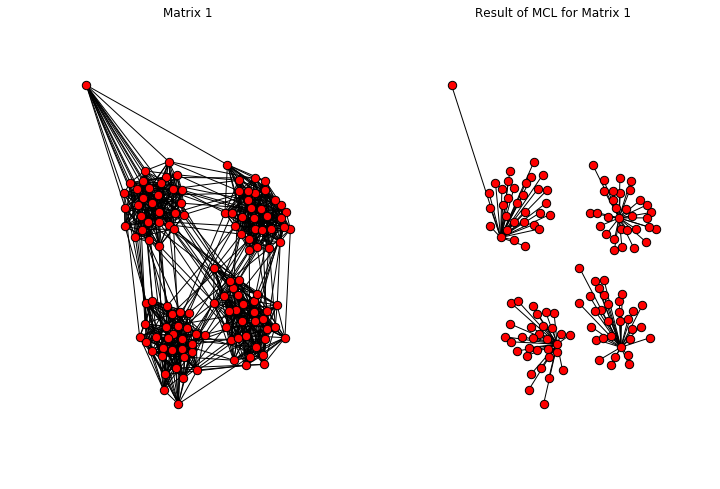

In [5]:
# For Matrix 1

X1 = MCL(A1, 2, 2, 0.01)

figN, axN = plt.subplots()
figN.set_size_inches(12,8)

plt.subplot(1, 2, 1)
nx.draw(nx.from_numpy_matrix(A1), pos, node_size=70, node_color='r')
plt.title('Matrix 1')

plt.subplot(1, 2, 2)
nx.draw(nx.from_numpy_matrix(X1), pos, node_size=70, node_color='r')
plt.title('Result of MCL for Matrix 1')

plt.show()

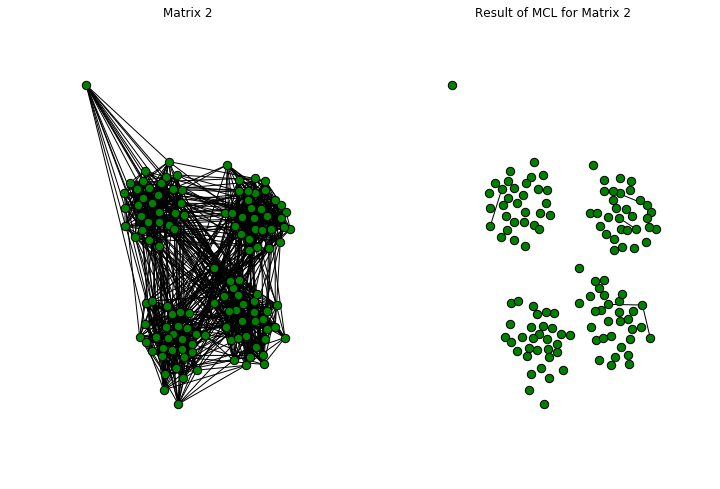

In [6]:
# For Matrix 2

X2 = MCL(A2, 2, 2, 0.01)

figN, axN = plt.subplots()
figN.set_size_inches(12,8)

plt.subplot(1, 2, 1)
nx.draw(nx.from_numpy_matrix(A2), pos, node_size=70, node_color='g')
plt.title('Matrix 2')

plt.subplot(1, 2, 2)
nx.draw(nx.from_numpy_matrix(X2), pos, node_size=70, node_color='g')
plt.title('Result of MCL for Matrix 2')

plt.show()

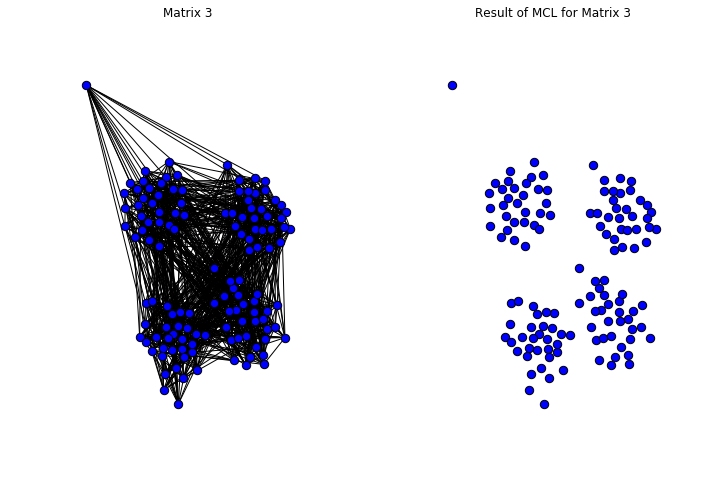

In [7]:
# For Matrix 3

X3 = MCL(A3, 2, 2, 0.01)

figN, axN = plt.subplots()
figN.set_size_inches(12,8)

plt.subplot(1, 2, 1)
nx.draw(nx.from_numpy_matrix(A3), pos, node_size=70, node_color='b')
plt.title('Matrix 3')

plt.subplot(1, 2, 2)
nx.draw(nx.from_numpy_matrix(X3), pos, node_size=70, node_color='b')
plt.title('Result of MCL for Matrix 3')

plt.show()

The effects of the parameters $\alpha$, $p$ and $\theta$ can be formulated as follows:
* $\theta\in(0,1)$ -- determines the level beyond which the path transition probabilities are considered important enough to contibute to a community. A high $\theta$ makes the detection less sensitive, and beyond some threshold may cause the algorithm to fail to detect anything. Lower significance thresholdmakes the MCL more likely to find larger communities;
* $p\geq1$ integer: determines how far the periphery of a community may spread. The higher the $p$ the the less sensitive is community detection to the separation of nodes, and the more likely it is to find larger communities;
* $\alpha>1$ real: governs the damping. With high $\alpha$ highly probable transitions stay probable in the final transition kernel $\pi_{ij}'$, while moderate become negligible. That is why with low $\alpha$ larger communities are detected, whereas high damping exponent tends to detect more concentrated, tighter communities, is any at all.

In [8]:
def show_four_plots(A1, p_vals, a_vals, t_vals):
    
    figN, axN = plt.subplots()
    figN.set_size_inches(16,16)
    
    plt.subplot(2, 2, 1)
    nx.draw(nx.from_numpy_matrix(A1), pos, node_size=70, node_color='r')
    plt.title('Original matrix')

    plt.subplot(2, 2, 2)
    nx.draw(nx.from_numpy_matrix(MCL(A1, p_vals[0], a_vals[0] , t_vals[0])), pos, node_size=70, node_color='g')
    plt.title('p='+str(p_vals[0])+','+'alpha='+str(a_vals[0])+', '+'threshold='+str(t_vals[0]))

    plt.subplot(2, 2, 3)
    nx.draw(nx.from_numpy_matrix(MCL(A1, p_vals[1], a_vals[1] , t_vals[1])), pos, node_size=70, node_color='b')
    plt.title('p='+str(p_vals[1])+', '+'alpha='+str(a_vals[1])+', '+'threshold='+str(t_vals[1]))

    plt.subplot(2, 2, 4)
    nx.draw(nx.from_numpy_matrix(MCL(A1, p_vals[2], a_vals[2] , t_vals[2])), pos, node_size=70, node_color='y')
    plt.title('p='+str(p_vals[2])+', '+'alpha='+str(a_vals[2])+', '+'threshold='+str(t_vals[2]))

    return plt.show()

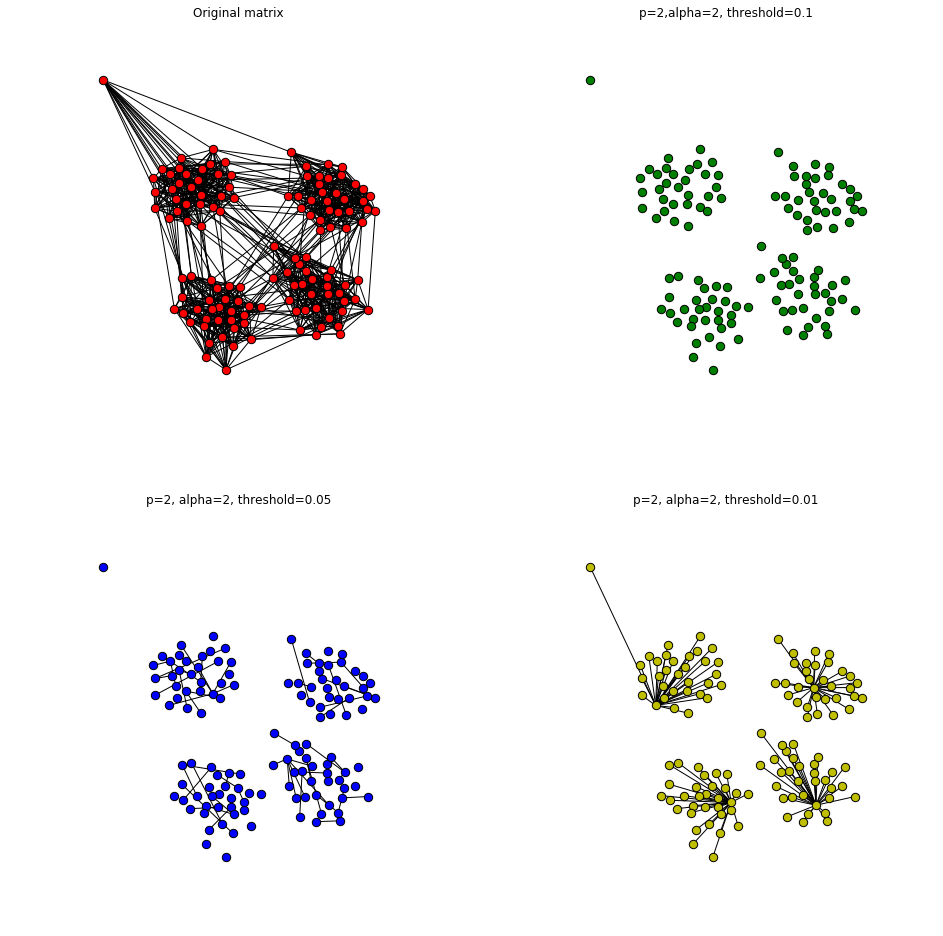

In [9]:
show_four_plots(A1, [2,2,2], [2,2,2], [0.1,0.05,0.01])

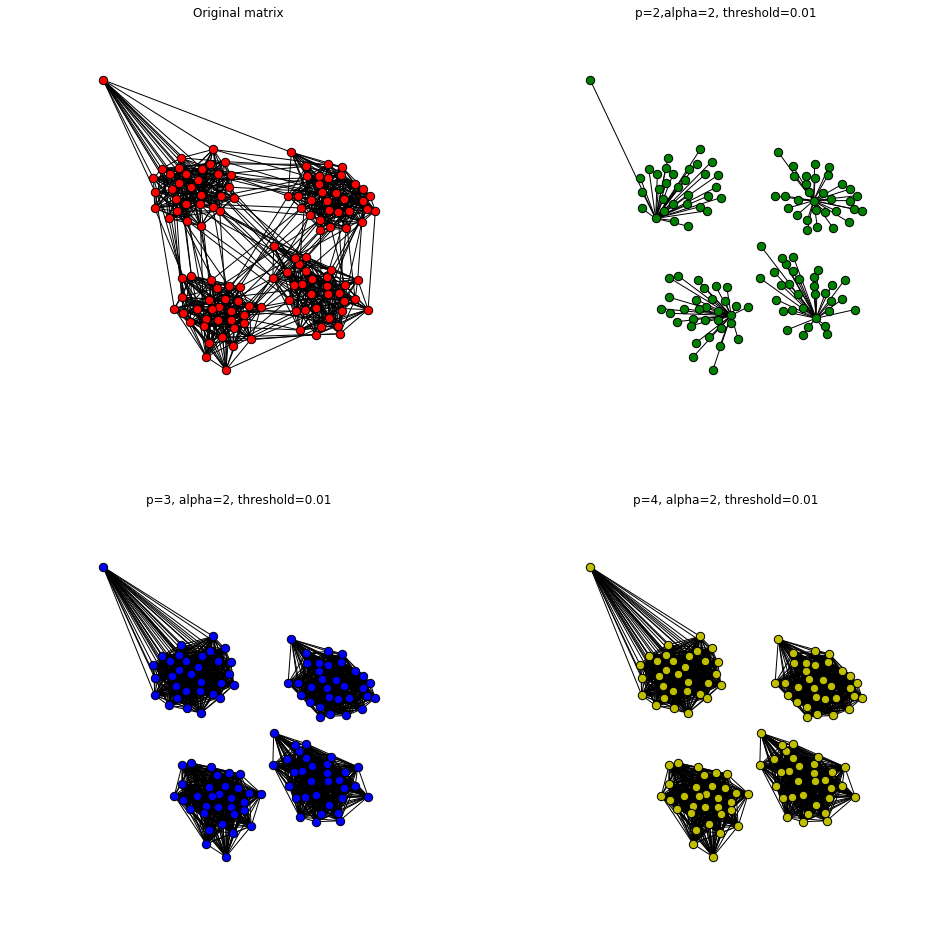

In [10]:
show_four_plots(A1, [2,3,4], [2,2,2], [0.01,0.01,0.01])

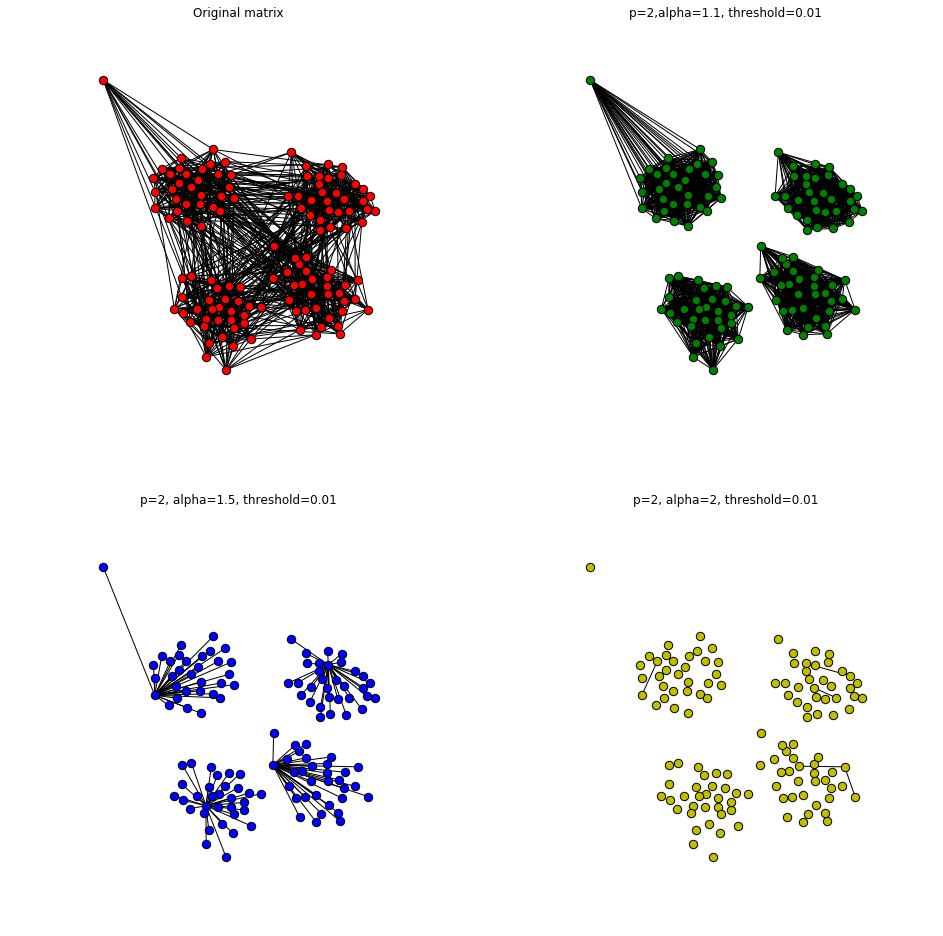

In [11]:
show_four_plots(A2, [2,2,2], [1.1,1.5,2], [0.01,0.01,0.01])

In conclusion:
* the **size** of communitites detected is **inversely** related to $\alpha$;
* $p$ regulates the scouting radius of the underlying random walk, and **higher values** make the procedure less sensitive to the micro-level topology of the conncetivity graph, which causes detection of **coarser communities**;
* The significance level $\theta$ is **inversely** proportional to the sensitivity of the procedure: **higher values** make MCL ignore more probable paths between nodes, which leads to **breaking up of large communities** into finer, more concentrated ones. The **major effect** of significance threshold is on the **size of the region** of $\alpha$ and $p$, where the procedure detect anything at all;
* the MCL is **extrmely sensitive to noise or missing links** in the connectivity data.

## Task 2

Load [Yahoo Music network](https://www.hse.ru/data/2016/03/15/1127704844/music_data.mat). Edges in this network appear if enough number of users have given ratings to both music bands. Note, that edges are weighted with similarity of the ratings.

* Implement *multilevel spectral recursive partitioning* algorithm that was described during the lecture
* Visualize community structure of the network and output some of the dense clusters (with interpretation, if you can)

In [12]:
music_data = io.loadmat('music_data.mat')
A = spma.csc_matrix(music_data['A'], dtype = np.float)

In [13]:
def cluster(A, T = 100, Q = None, _index = None, mincut = False, depth = float('inf'), density_threshold = .05):
# If the recursion depth is exceeded return
    if depth <= 0 :
        return np.arange(A.shape[0])
    
# Create master indices if necessary
    if _index is None :
        _index = np.arange(A.shape[0])
        
# Compute the global similarity of each element
    deg = A.sum(axis = 1).getA1()
    
# Detect non-isolated items
    nz, zz = np.where(deg != 0)[0], np.where(deg == 0)[0]
    if len(nz) < T :
        return np.arange(len(deg))
    
    S = A[:,nz].tocsr()[nz,:].tocsc()

    if mincut:
        L = spma.diags(deg[nz], offsets = 0) - S # unnormalised laplacian
        l, e = spma.linalg.eigs(L, k=2, which='SM', v0=np.ones(L.shape[1], np.float)) # eigenvector for the 2nd least eigenvalue
        e = e[:, np.argmax(l)].real # real part of the second largest eigenvector
    else:
        L = spma.diags(1.0/deg[nz], offsets=0).dot(S)
        l, e = spma.linalg.eigs(L, k=2, v0=np.ones(L.shape[1], np.float))
        e = e[:, np.argmin(l)].real # real part of the second largest eigenvector

# Set the threshold: use the zero threshold
    t = 0
    
# Separate the items in two sets: left(n) and right (p)
    n, p = np.where( e <= t )[ 0 ], np.where( e > t )[ 0 ]
    N, P = S[:,n].tocsr()[n,:].tocsc( ), S[:,p].tocsr()[p,:].tocsc( )
    
# Compute the densities
    nd, pd = N.nnz, P.nnz
    nw, pw = len(n) * (len(n) - 1.0), len(p) * (len(p) - 1.0)
    
# If there is enough elements in a set, split it.
    if (len(p) > T) and (density_threshold * pw > pd):
        p = p[cluster(P, T = T, Q = Q, _index = _index[nz[p]],
            mincut = mincut, depth = depth - 1, density_threshold = density_threshold)]
        
    if (len(n) > T) and (density_threshold * nw > nd):
        n = n[cluster(N, T = T, Q = Q, _index = _index[nz[n]],
            mincut = mincut, depth = depth - 1, density_threshold = density_threshold)]

# Update the queue of clusters
    if Q is not None:
        Q.append(_index[nz[p]])
        Q.append(_index[nz[n]])
        Q.append(_index[zz])

# Reorder the clusters so that the denser groups are shifted to the left
    if nd*pw > pd*nw:
        p, n = n, p
    return np.concatenate((zz, nz[n], nz[p]))

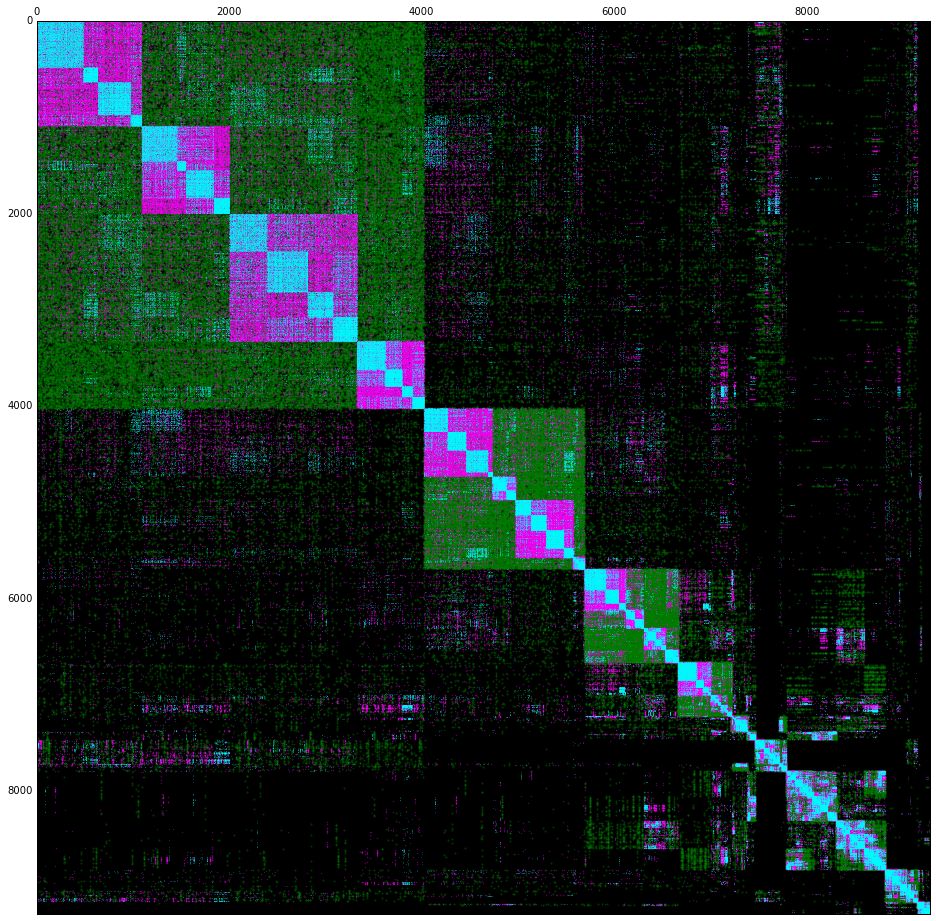

In [14]:
fig = plt.figure(figsize = (16, 16))
axs = fig.add_subplot(1, 1, 1, axisbg = 'black')

I = cluster(A, T = 10, depth = 4, density_threshold = .3)
axs.spy(A[:,I].tocsr()[I,:], marker = '.', markersize = 3, precision = 0, alpha = .35, color = 'green')

I = cluster(A, T = 10, depth = 6, density_threshold = .3)
axs.spy(A[:,I].tocsr()[I,:], marker = '.', markersize = 2, precision = 0, alpha = .25, color = 'magenta')

I = cluster(A, T = 10, depth = 8, density_threshold = .3)
axs.spy(A[:,I].tocsr()[I,:], marker = '.', markersize = 1, precision = 0, alpha = .25, color = 'cyan')

In [15]:
cluster_tree = list()
I = cluster(A, T = 10, Q = cluster_tree, depth = 13, density_threshold = .3)

## Compute the density
den = np.zeros(len(cluster_tree), np.float )
dia = A.diagonal()

for i, c in enumerate(cluster_tree):
    if len(c) < 2 : continue
    within = A[:,c].tocsr()[c,:].nnz
    weight = len(c) * (len(c) - 1.0)
    den[i] = (within / weight)

## Reorder
order = np.argsort(den)
top = order[ ~np.isnan(den[order])][::-1]

In [16]:
pd.set_option('display.max_colwidth', 1000)

In [17]:
b = pd.DataFrame(den, columns=['density'])
b['size'] = [len(x) for x in cluster_tree]
b['artists'] = [', '.join([s.strip() for s in music_data['artists'][x]]) for x in cluster_tree]

In [18]:
# TOP-15 densiest clusters

b.sort_values('density', ascending=False).head(15)

,density,size,artists
796,0.892857,8,"Mojo Nixon, Tiny Tim, Garrison Keillor, Dr. Elmo, Tales From The Crypt, Pokemon, Elmo & Patsy, Bob Rivers"
990,0.777778,9,"George Gershwin, Count Basie Orchestra, Brahms, Frank Sinatra/Tommy Dorsey, Carl Orff, The Duke Ellington Orchestra, Frank Sinatra/Duke Ellington, Schubert, Ella Fitzgerald/Louis Armstrong"
460,0.694444,9,"Rollins Band, Infectious Grooves, Ministry, Helmet, Urban Dance Squad, Butthole Surfers, Henry Rollins, Suicidal Tendencies, Body Count"
817,0.676923,26,"Charlie Robison, Cooder Graw, Cross Canadian Ragweed, Radney Foster, The Highwaymen, Roger Creager, Slaid Cleaves, Kelly Willis, Kevin Fowler, Ray Wylie Hubbard, Billy Joe Shaver, Cross Canadian Ragweed, David Allan Coe, Cory Morrow, Jack Ingram, Guy Clark, Jerry Jeff Walker, Bruce Robison, Robert Earl Keen, Reckless Kelly, Keith Whitley, Chris Knight, The Great Divide, Kris Kristofferson, Max Stalling, Gary P. Nunn"
903,0.654971,19,"Van Truong, Quartango, Thanh Lam, Andy Hui, Trish, Misia, Leon Lai, Geoffrey Oryema, Coco Lee, Aaron Kwok, Sammi Cheng, Baba Alade, Jacky Cheung, Takillacta, KSM, Tiziano Ferro, Sonny Le, Phuong Thanh, Coco Lee"
463,0.637363,14,"Melvins, Fantomas, Clutch, Les Claypool's Frog Brigade, Tub Ring, Buckethead, Sausage, Colonel Les Claypool's Fearless Flying Frog Brigade, Secret Chiefs 3, Les Claypool, Mr. Bungle, Mike Patton, John Zorn, Lard"
997,0.626829,41,"Wiener Philharmoniker, English Chamber Orchestra, Krystian Zimerman, The King's Singers, New York Philharmonic, Roberto Michelucci, Orchestre National De France, Isaac Stern, Kyung Wha Chung, Emil Gilels, New York Pro Music Antiqua, Gregorian Chants, Royal Philharmonic Orchestra, Yo-Yo Ma, Maria Joao Pires, Scottish Chamber Orchestra, The Cleveland Orchestra, Atlanta Symphony Orchestra, London Symphony Orchestra, Sviatoslav Richter, RIAS-Symphonie-Orchester Berlin, Chicago Symphony Orchestra, New Philharmonia Orchestra, Victoria Postnikova, Academy Of St. Martin-In-The-Fields, Columbia Symphony Orchestra, Antonio Vivaldi, Izzy, Claudio Arrau, Berlin Philharmonic Orchestra, Original Score, London Philharmonic Orchestra, Berliner Philharmoniker, Boston Symphony Orchestra, Beethoven, Orchestre Symphonique De Montreal, San Francisco Symphony, Philadelphia Orchestra, Gilbert Johnson, Boston Pops, Yefim Bronfman"
925,0.604396,14,"The Temptations, Al Green, Tina Turner, Barry White, Natalie Cole, Ray Charles, The Commodores, The O'Jays, Rick James, Terence Trent D'Arby, Chic, Lionel Richie, Roberta Flack, Earth, Wind & Fire"
22,0.600000,6,"Mo Thugs Family, Doggy's Angels, Krayzie Bone, Mo Thugs, Flesh-N-Bone, Chico & Coolwadda"
217,0.590090,37,"Dot Allison, Nuspirit Helsinki, Le Gooster, Dubstar, Husikesque, Vanessa Daou, United Future Organization, Kid Loco, The Dining Rooms, 1 Giant Leap, Gilles Peterson, Red Snapper, Caia, Dzihan & Kamien, Baby Mammoth, Boy George, Baby Fox, Blue States, Bomb The Bass, Gotan Project, Waldeck, Mr. Scruff, Stereo MC's, Urchin, De Phazz, Fila Brazillia, Stereotyp, Projections, Etro Anime, The Januaries, Nitin Sawhney, Jazzanova, Tosca, Lemon Jelly, Flunk, The Tao Of Groove, Bonobo"
